In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pandas")

import pandas as pd
import os
#!pip install pandas openpyxl

In [ ]:
# Directorio que contiene los archivos Excel
folder_path = 'data/precio/'

# Lista para almacenar los DataFrames
data_frames = []

from datetime import timedelta
import pandas as pd

# Función para ajustar la fecha y hora, incluyendo el manejo de días con 23, 24 o 25 horas
def ajustar_fecha(row):
    dia = pd.to_datetime(row['Día'], errors='coerce')
    hora = row['Hora']
    if hora==25:
        return dia.replace(hour=hora - 2, minute=59, second=58)
    return dia.replace(hour=hora - 1, minute=59, second=59)

    
# Recorremos cada archivo en el directorio
for file_name in os.listdir(folder_path):
    if file_name.endswith('.xls') or file_name.endswith('.xlsx'):
        # Ruta completa del archivo
        file_path = os.path.join(folder_path, file_name)
        print(file_path)
        
        # Leemos el archivo Excel
        xls = pd.ExcelFile(file_path)
        
        # Parseamos la primera hoja
        sheetX = xls.parse(0)
        
        # Renombramos las columnas usando la fila 3 y extraemos las filas a partir de la 4
        data = sheetX.rename(columns=sheetX.iloc[3])[4:]
        
        # Seleccionamos las columnas de interés (asegúrate de que los nombres coincidan)
        data_filtered = data[['Día', 'Hora', 'Término energía PVPC\nFEU = TEU + TCU\n€/MWh consumo']]
        
        data_filtered['fecha_hora'] = data_filtered.apply(ajustar_fecha, axis=1)
        data_filtered = data_filtered.rename(columns={"Término energía PVPC\nFEU = TEU + TCU\n€/MWh consumo": "€/MWh"})[['fecha_hora', '€/MWh']]

        # Agregamos el DataFrame a la lista
        data_frames.append(data_filtered)

# Concatenamos todos los DataFrames en uno solo
final_data = pd.concat(data_frames, ignore_index=True)

# Guardamos el resultado en un archivo CSV o Excel si es necesario
final_data.to_csv('data_precios_unificado.csv', index=False)
# O, si prefieres guardar en formato Excel
# final_data.to_excel('resultado_final.xlsx', index=False)

In [8]:
final_data = pd.read_csv('data_precios_unificado.csv')
final_data.sort_values(by = 'fecha_hora').reset_index(drop = True)

,fecha_hora,€/MWh
0,2022-10-01 00:59:59,285.146316
1,2022-10-01 01:59:59,212.135245
2,2022-10-01 02:59:59,197.782570
3,2022-10-01 03:59:59,189.817280
4,2022-10-01 04:59:59,182.521315
...,...,...
16819,2024-08-31 19:59:59,156.483840
16820,2024-08-31 20:59:59,168.353748
16821,2024-08-31 21:59:59,192.896754
16822,2024-08-31 22:59:59,182.597874


In [9]:
final_data.isna().sum()

fecha_hora    0
€/MWh         0
dtype: int64

In [10]:
import pandas as pd

# Función para clasificar los periodos según la fecha y hora
def clasificar_periodo(fecha_hora):
    # Extraer la hora y el día de la semana
    hora = fecha_hora.hour
    dia_semana = fecha_hora.weekday()  # Lunes = 0, Domingo = 6

    # Clasificación para sábados, domingos y festivos (todo el día es Valle)
    if dia_semana >= 5:  # Sábado (5) y Domingo (6)
        return 'Valle'
    
    # Clasificación para días entre lunes y viernes
    if (hora >= 0) and (hora < 10):
        return 'Valle'
    elif (hora >= 10) and (hora < 14):
        return 'Llano'
    elif (hora >= 14) and (hora < 18):
        return 'Valle'
    elif (hora >= 18) and (hora < 19):
        return 'Llano'
    elif (hora >= 19) and (hora < 22):
        return 'Punta'
    elif (hora >= 22) and (hora < 24):
        return 'Llano'
    else:
        return 'Desconocido'

# Función para calcular la media diaria por periodo y rellenar fines de semana
def calcular_media_diaria_por_periodo(df):
    # Asegurarse de que la columna de fecha es de tipo datetime
    df['fecha_hora'] = pd.to_datetime(df['fecha_hora'])

    # Crear una columna con el periodo basado en la fecha y hora
    df['periodo'] = df['fecha_hora'].apply(clasificar_periodo)

    # Crear una columna con la fecha (sin la hora)
    df['fecha'] = df['fecha_hora'].dt.date

    # Calcular la media diaria por cada periodo
    medias_diarias = df.groupby(['fecha', 'periodo'])['€/MWh'].mean().unstack()

    # Detectar fines de semana (Sábados y Domingos)
    df['dia_semana'] = df['fecha_hora'].dt.weekday
    fines_semana = df[df['dia_semana'] >= 5]['fecha'].unique()  # Solo sábados y domingos
    
    # Para cada día del fin de semana, rellenar los precios de Punta y Llano con el precio de Valle
    for dia in fines_semana:
        if 'Valle' in medias_diarias.columns:
            precio_valle = medias_diarias.loc[dia, 'Valle']
            medias_diarias.loc[dia, 'Punta'] = precio_valle
            medias_diarias.loc[dia, 'Llano'] = precio_valle

    return medias_diarias

In [11]:
medias_diarias_llano_punta_valle = calcular_media_diaria_por_periodo(final_data)
medias_diarias_llano_punta_valle

periodo,Llano,Punta,Valle
fecha,,,
2022-10-01,216.937627,216.937627,216.937627
2022-10-02,238.561577,238.561577,238.561577
2022-10-03,351.282714,432.649761,319.078946
2022-10-04,371.324199,494.452371,362.289320
2022-10-05,337.913411,453.173332,359.987677
...,...,...,...
2024-08-27,185.990232,241.149503,144.445452
2024-08-28,187.933779,236.859297,147.329026
2024-08-29,202.326771,235.875252,154.862677


In [12]:
final_data.sort_values(by = 'fecha_hora')

,fecha_hora,€/MWh,periodo,fecha,dia_semana
552,2022-10-01 00:59:59,285.146316,Valle,2022-10-01,5
553,2022-10-01 01:59:59,212.135245,Valle,2022-10-01,5
554,2022-10-01 02:59:59,197.782570,Valle,2022-10-01,5
555,2022-10-01 03:59:59,189.817280,Valle,2022-10-01,5
556,2022-10-01 04:59:59,182.521315,Valle,2022-10-01,5
...,...,...,...,...,...
9378,2024-08-31 19:59:59,156.483840,Valle,2024-08-31,5
9379,2024-08-31 20:59:59,168.353748,Valle,2024-08-31,5
9380,2024-08-31 21:59:59,192.896754,Valle,2024-08-31,5
9381,2024-08-31 22:59:59,182.597874,Valle,2024-08-31,5


In [13]:
medias_diarias_llano_punta_valle.to_csv('medias_diarias_llano_punta_valle_oct_22_ago_24.csv')
final_data.to_csv('data_precios_unificados_llano_punta_valle.csv', index=False)

In [15]:
medias_diarias_llano_punta_valle

periodo,Llano,Punta,Valle
fecha,,,
2022-10-01,216.937627,216.937627,216.937627
2022-10-02,238.561577,238.561577,238.561577
2022-10-03,351.282714,432.649761,319.078946
2022-10-04,371.324199,494.452371,362.289320
2022-10-05,337.913411,453.173332,359.987677
...,...,...,...
2024-08-27,185.990232,241.149503,144.445452
2024-08-28,187.933779,236.859297,147.329026
2024-08-29,202.326771,235.875252,154.862677


In [16]:
final_data.isna().sum()

fecha_hora    0
€/MWh         0
periodo       0
fecha         0
dia_semana    0
dtype: int64

In [17]:
medias_diarias_llano_punta_valle.isna().sum()

periodo
Llano    0
Punta    0
Valle    0
dtype: int64

In [18]:
medias_diarias_llano_punta_valle = medias_diarias_llano_punta_valle.asfreq('D') 

<Figure size 1800x1200 with 0 Axes>

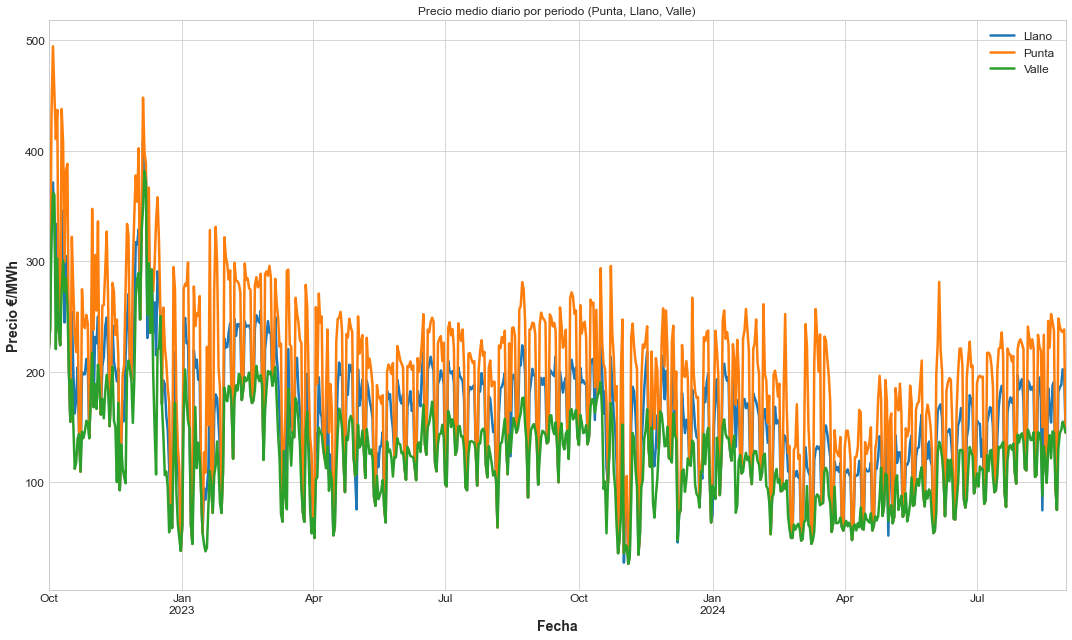

In [19]:
import matplotlib.pyplot as plt

# Establecer la resolución (DPI) más alta para mayor nitidez
plt.figure(dpi=300)

# Personalizar el gráfico para mayor claridad
plt.style.use('seaborn-whitegrid')  # Estilo limpio y con buen contraste
medias_diarias_llano_punta_valle.plot(
    figsize=(15, 9), 
    title="Precio medio diario por periodo (Punta, Llano, Valle)", 
    linewidth=2.5,  # Grosor de línea para mayor visibilidad
    color=['#1f77b4', '#ff7f0e', '#2ca02c']  # Colores diferenciables para las líneas
)

# Etiquetas y título
plt.ylabel("Precio €/MWh", fontsize=14, fontweight='bold')
plt.xlabel("Fecha", fontsize=14, fontweight='bold')

# Aumentar el tamaño de las etiquetas de los ejes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Mostrar leyenda con mejor visibilidad
plt.legend(loc='best', fontsize=12)

# Ajustar márgenes para que el gráfico no quede tan pegado a los bordes
plt.tight_layout()

# Mostrar el gráfico
plt.show()


In [30]:
medias_diarias_llano_punta_valle.describe()

periodo,Llano,Punta,Valle
count,701.000000,701.000000,701.000000
mean,126.591634,160.748469,126.111228
std,90.827201,113.383386,51.174214
min,0.000000,0.000000,26.302984
25%,0.000000,0.000000,92.564976
50%,152.012174,200.242142,124.328093
75%,192.355105,238.391201,148.812338
max,408.221858,494.452371,381.497382


In [20]:
import pandas as pd
medias_demanda_punta_valle_llano = pd.read_csv('demanda_punta_valle_llano.csv')[['Fecha', 'Real_Llano', 'Real_Punta', 'Real_Valle']]
medias_demanda_punta_valle_llano.sort_values(by = 'Fecha')

,Fecha,Real_Llano,Real_Punta,Real_Valle
0,2022-10-01,24323.513,24323.513,24323.513
1,2022-10-02,22691.646,22691.646,22691.646
2,2022-10-03,29573.196,31173.437,25146.725
3,2022-10-04,30106.177,31426.656,26395.682
4,2022-10-05,29999.780,31309.654,26446.464
...,...,...,...,...
696,2024-08-27,34001.383,35797.914,30003.086
697,2024-08-28,34471.484,35937.125,30530.009
698,2024-08-29,34156.224,35162.019,30294.763
699,2024-08-30,33351.491,34426.190,29808.493


In [21]:
medias_demanda_punta_valle_llano.rename(columns={'Real_Llano': 'Demanda_Llano', 'Real_Valle': 'Demanda_Valle', 'Real_Punta': 'Demanda_Punta'}, inplace = True)
medias_demanda_punta_valle_llano

,Fecha,Demanda_Llano,Demanda_Punta,Demanda_Valle
0,2022-10-01,24323.513,24323.513,24323.513
1,2022-10-02,22691.646,22691.646,22691.646
2,2022-10-03,29573.196,31173.437,25146.725
3,2022-10-04,30106.177,31426.656,26395.682
4,2022-10-05,29999.780,31309.654,26446.464
...,...,...,...,...
696,2024-08-27,34001.383,35797.914,30003.086
697,2024-08-28,34471.484,35937.125,30530.009
698,2024-08-29,34156.224,35162.019,30294.763
699,2024-08-30,33351.491,34426.190,29808.493


<Figure size 1800x1200 with 0 Axes>

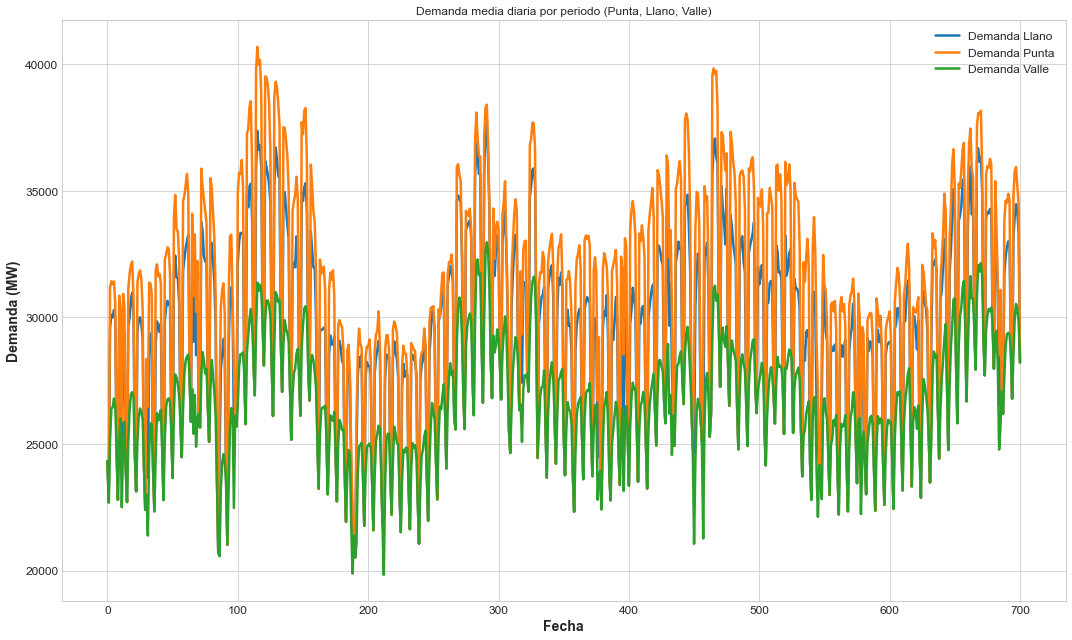

In [33]:
import matplotlib.pyplot as plt

# Establecer la resolución (DPI) más alta para mayor nitidez
plt.figure(dpi=300)

# Personalizar el gráfico para mayor claridad
plt.style.use('seaborn-whitegrid')  # Estilo limpio y con buen contraste

# Graficar las tres columnas de demanda en diferentes colores y con grosor ajustado
medias_demanda_punta_valle_llano.plot(
    figsize=(15, 9), 
    title="Demanda media diaria por periodo (Punta, Llano, Valle)", 
    linewidth=2.5,  # Grosor de línea para mayor visibilidad
    color=['#1f77b4', '#ff7f0e', '#2ca02c']  # Colores diferenciables para las líneas
)

# Etiquetas y título
plt.ylabel("Demanda (MW)", fontsize=14, fontweight='bold')
plt.xlabel("Fecha", fontsize=14, fontweight='bold')

# Aumentar el tamaño de las etiquetas de los ejes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Mostrar leyenda con mejor visibilidad
plt.legend(['Demanda Llano', 'Demanda Punta', 'Demanda Valle'], loc='best', fontsize=12)

# Ajustar márgenes para que el gráfico no quede tan pegado a los bordes
plt.tight_layout()

# Mostrar el gráfico
plt.show()


In [22]:
medias_diarias_llano_punta_valle = medias_diarias_llano_punta_valle.reset_index()

In [23]:
type(medias_diarias_llano_punta_valle['fecha'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [24]:
type(medias_demanda_punta_valle_llano['Fecha'][0])

str

In [25]:
medias_demanda_punta_valle_llano['Fecha'] = pd.to_datetime(medias_demanda_punta_valle_llano['Fecha'], errors='coerce')
medias_demanda_punta_valle_llano['Fecha'] = medias_demanda_punta_valle_llano['Fecha'].dt.date

In [32]:
type(medias_demanda_punta_valle_llano['Fecha'][0])
type(pd.to_datetime(medias_demanda_punta_valle_llano['Fecha']).dt.date[0])

datetime.date

In [34]:
medias_diarias_llano_punta_valle['fecha'] = medias_diarias_llano_punta_valle['fecha'].dt.date

In [35]:
df_merged = pd.merge(medias_demanda_punta_valle_llano, medias_diarias_llano_punta_valle, left_on='Fecha', right_on='fecha', how='inner')
df_merged

,Fecha,Demanda_Llano,Demanda_Punta,Demanda_Valle,fecha,Llano,Punta,Valle
0,2022-10-01,24323.513,24323.513,24323.513,2022-10-01,216.937627,216.937627,216.937627
1,2022-10-02,22691.646,22691.646,22691.646,2022-10-02,238.561577,238.561577,238.561577
2,2022-10-03,29573.196,31173.437,25146.725,2022-10-03,351.282714,432.649761,319.078946
3,2022-10-04,30106.177,31426.656,26395.682,2022-10-04,371.324199,494.452371,362.289320
4,2022-10-05,29999.780,31309.654,26446.464,2022-10-05,337.913411,453.173332,359.987677
...,...,...,...,...,...,...,...,...
696,2024-08-27,34001.383,35797.914,30003.086,2024-08-27,185.990232,241.149503,144.445452
697,2024-08-28,34471.484,35937.125,30530.009,2024-08-28,187.933779,236.859297,147.329026
698,2024-08-29,34156.224,35162.019,30294.763,2024-08-29,202.326771,235.875252,154.862677
699,2024-08-30,33351.491,34426.190,29808.493,2024-08-30,199.630289,238.391201,150.595214


In [36]:
precio_diario_carburante = pd.read_csv('carburantes_precio_diario.csv')
precio_diario_carburante

,Fecha,Pai Gasolina 95 E5,Pvp Gasolina 95 E5,Pai Gasolina 98 E5,Pvp Gasolina 98 E5,Pai Gasóleo A habitual,Pvp Gasóleo A habitual,Pai Gasóleo Premium,Pvp Gasóleo Premium
0,2022-10-01,0.943,1.669,1.043,1.837,1.138,1.795,1.212,1.883
1,2022-10-02,0.943,1.670,1.043,1.836,1.138,1.795,1.212,1.883
2,2022-10-03,0.944,1.670,1.043,1.836,1.138,1.795,1.213,1.884
3,2022-10-04,0.945,1.672,1.043,1.836,1.139,1.796,1.213,1.884
4,2022-10-05,0.952,1.680,1.050,1.844,1.145,1.803,1.219,1.891
...,...,...,...,...,...,...,...,...,...
696,2024-08-27,0.835,1.541,0.946,1.721,0.831,1.428,0.919,1.532
697,2024-08-28,0.834,1.540,0.945,1.720,0.830,1.426,0.918,1.531
698,2024-08-29,0.832,1.537,0.943,1.717,0.828,1.423,0.916,1.528
699,2024-08-30,0.829,1.534,0.943,1.717,0.825,1.420,0.916,1.528


In [41]:
type(precio_diario_carburante['Fecha'][0])

str

In [42]:
precio_diario_carburante['Fecha'] = pd.to_datetime(precio_diario_carburante['Fecha'], errors='coerce')
precio_diario_carburante['Fecha'] = precio_diario_carburante['Fecha'].dt.date
precio_diario_carburante

,Fecha,Pai Gasolina 95 E5,Pvp Gasolina 95 E5,Pai Gasolina 98 E5,Pvp Gasolina 98 E5,Pai Gasóleo A habitual,Pvp Gasóleo A habitual,Pai Gasóleo Premium,Pvp Gasóleo Premium
0,2022-10-01,0.943,1.669,1.043,1.837,1.138,1.795,1.212,1.883
1,2022-10-02,0.943,1.670,1.043,1.836,1.138,1.795,1.212,1.883
2,2022-10-03,0.944,1.670,1.043,1.836,1.138,1.795,1.213,1.884
3,2022-10-04,0.945,1.672,1.043,1.836,1.139,1.796,1.213,1.884
4,2022-10-05,0.952,1.680,1.050,1.844,1.145,1.803,1.219,1.891
...,...,...,...,...,...,...,...,...,...
696,2024-08-27,0.835,1.541,0.946,1.721,0.831,1.428,0.919,1.532
697,2024-08-28,0.834,1.540,0.945,1.720,0.830,1.426,0.918,1.531
698,2024-08-29,0.832,1.537,0.943,1.717,0.828,1.423,0.916,1.528
699,2024-08-30,0.829,1.534,0.943,1.717,0.825,1.420,0.916,1.528


In [54]:
precio_diario_carburante.columns[1:].values

array(['Pai Gasolina 95 E5', 'Pvp Gasolina 95 E5', 'Pai Gasolina 98 E5',
       'Pvp Gasolina 98 E5', 'Pai Gasóleo A habitual',
       'Pvp Gasóleo A habitual', 'Pai Gasóleo Premium',
       'Pvp Gasóleo Premium'], dtype=object)

<Figure size 1800x1200 with 0 Axes>

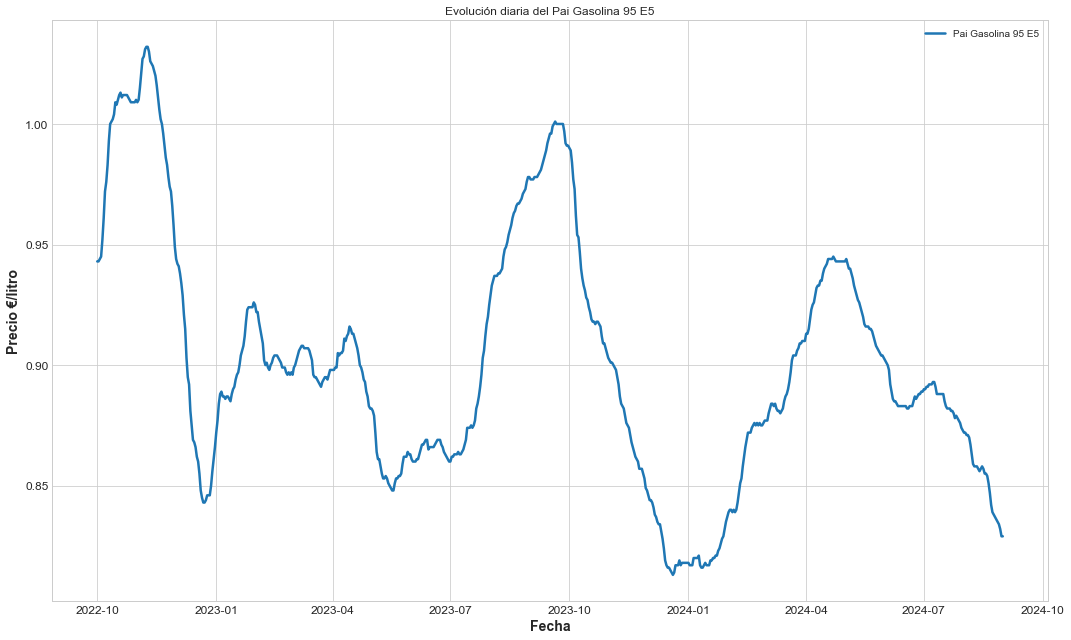

<Figure size 1800x1200 with 0 Axes>

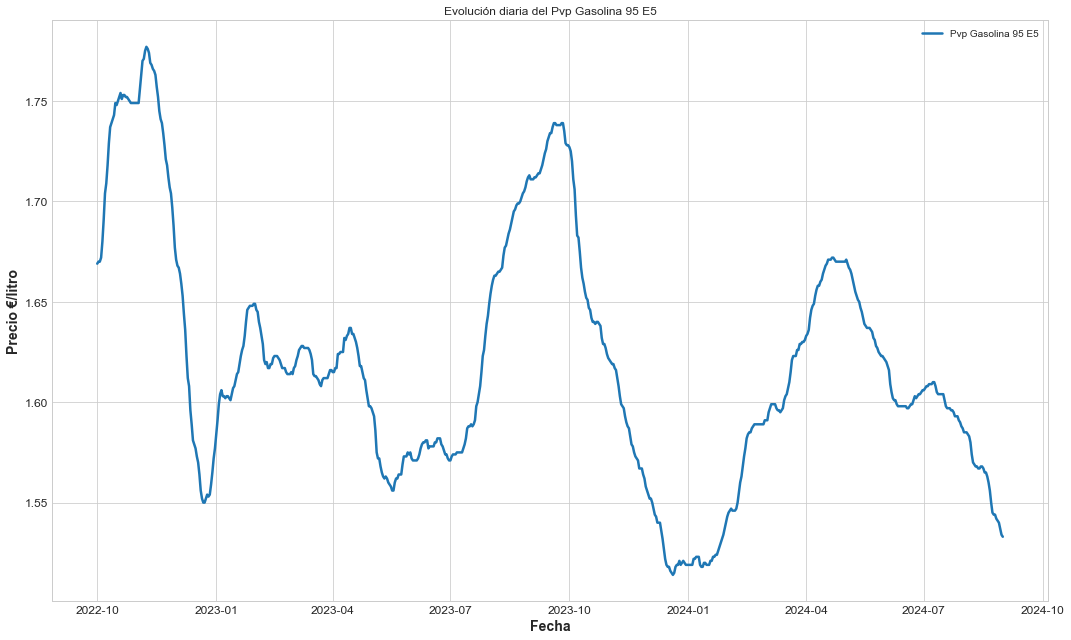

<Figure size 1800x1200 with 0 Axes>

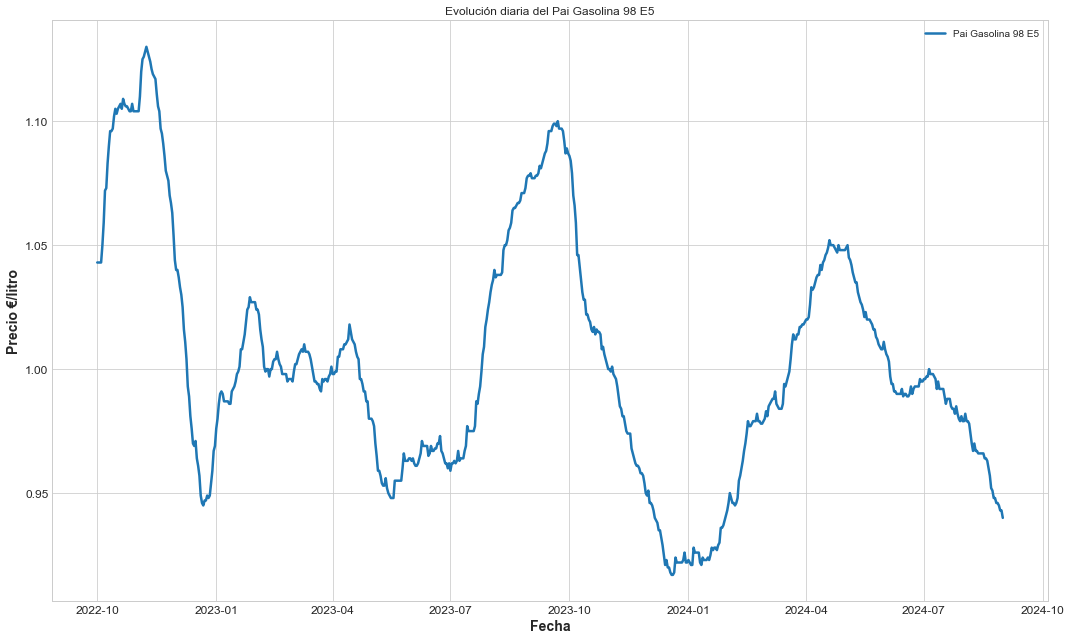

<Figure size 1800x1200 with 0 Axes>

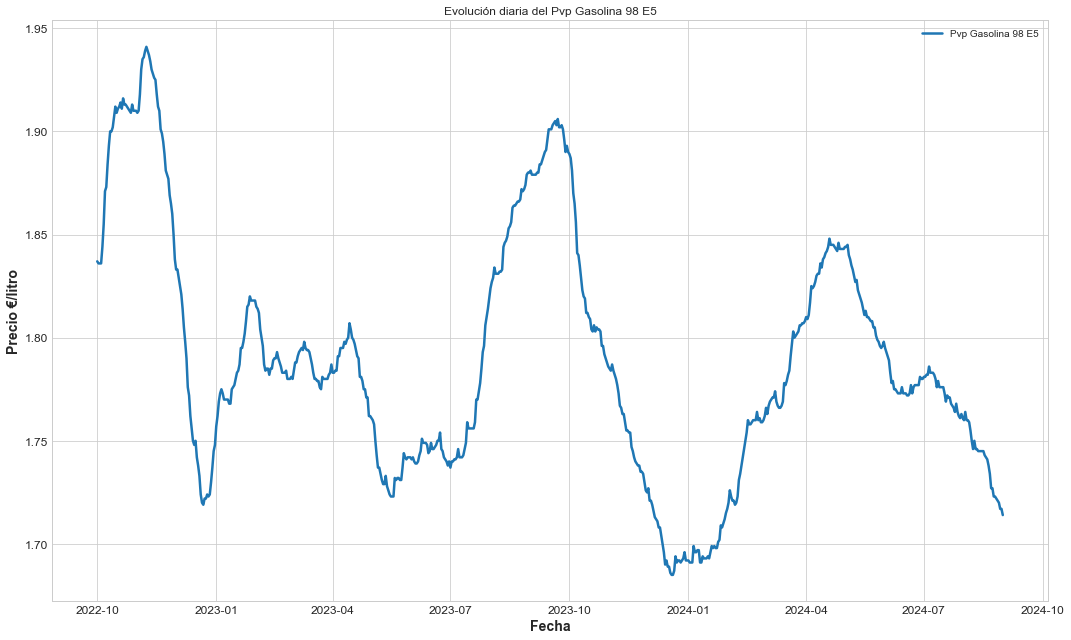

<Figure size 1800x1200 with 0 Axes>

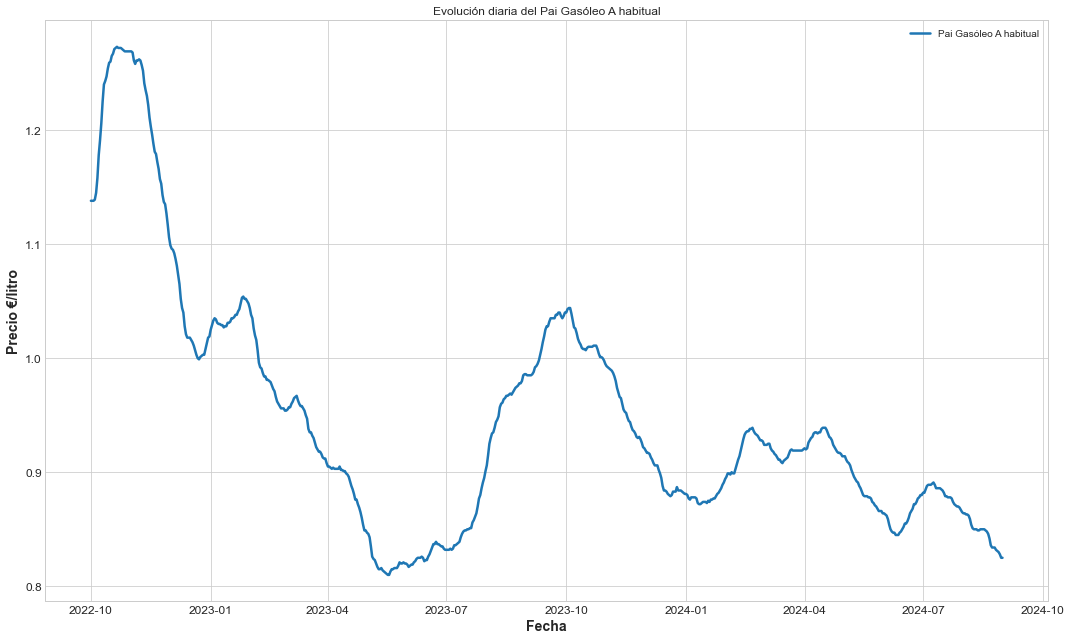

<Figure size 1800x1200 with 0 Axes>

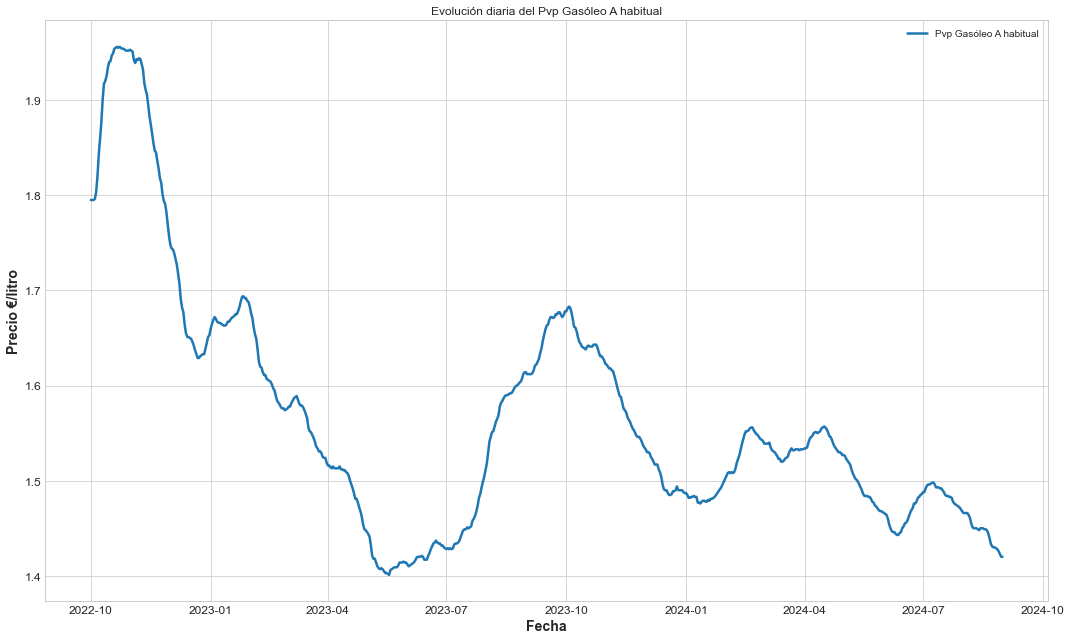

<Figure size 1800x1200 with 0 Axes>

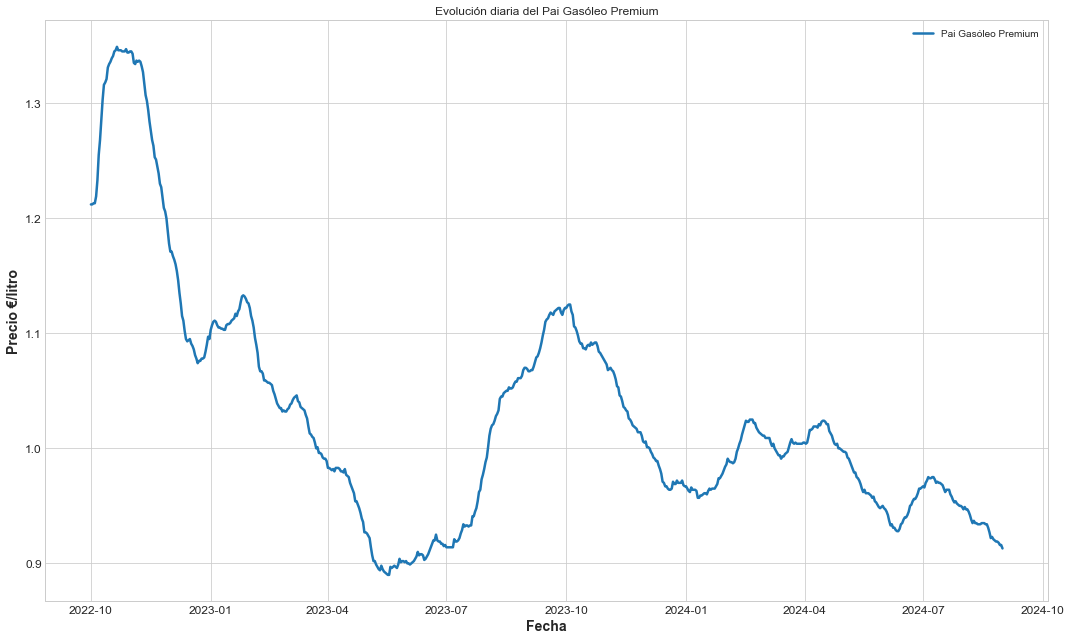

<Figure size 1800x1200 with 0 Axes>

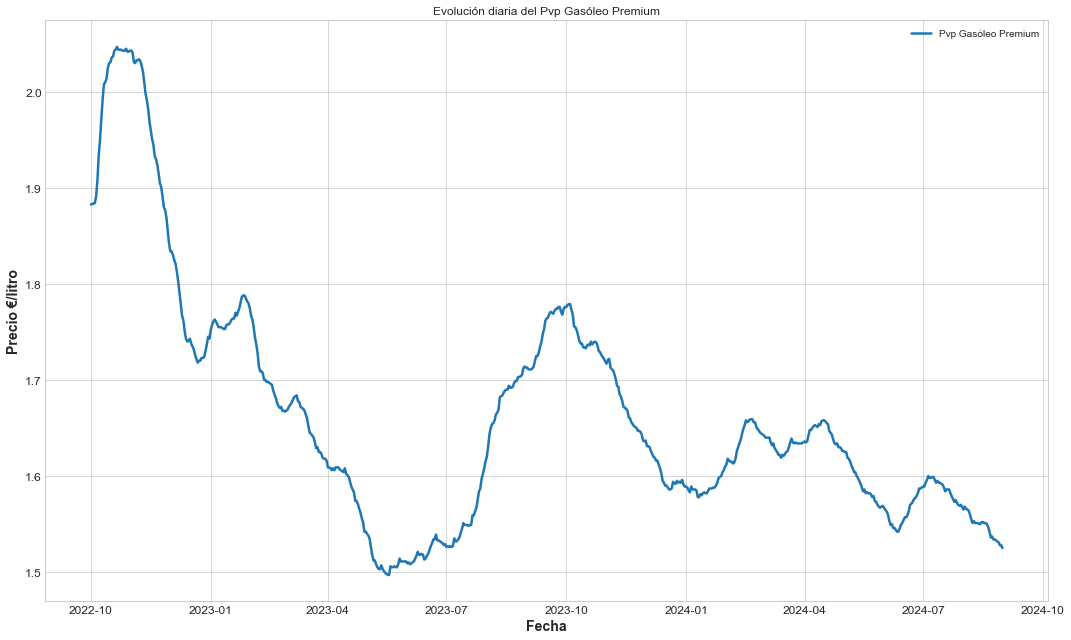

In [55]:
import matplotlib.pyplot as plt

for column in precio_diario_carburante.columns[1:].values:
# Establecer la resolución (DPI) más alta para mayor nitidez
    plt.figure(dpi=300)

    # Personalizar el gráfico para mayor claridad
    plt.style.use('seaborn-whitegrid')  # Estilo limpio y con buen contraste

    precio_diario_carburante.plot(
        x='Fecha',  # Eje X basado en la columna Fecha
        y=column,  # Eje Y basado en el precio PVP Gasolina 95 E5
        figsize=(15, 9), 
        linewidth=2.5,  # Grosor de línea para mayor visibilidad
        color='#1f77b4',  # Color de la línea
        title=f'Evolución diaria del {column}'  # Título del gráfico
    )

    # Etiquetas y título
    plt.ylabel("Precio €/litro", fontsize=14, fontweight='bold')
    plt.xlabel("Fecha", fontsize=14, fontweight='bold')

    # Aumentar el tamaño de las etiquetas de los ejes
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Ajustar márgenes para que el gráfico no quede tan pegado a los bordes
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()


In [44]:
type(df_merged['Fecha'][0])
precio_diario_carburante['Fecha'] = pd.to_datetime(precio_diario_carburante['Fecha'], errors='coerce').dt.date

In [45]:
df_merged_1 = pd.merge(df_merged, precio_diario_carburante, left_on='Fecha', right_on='Fecha', how='inner')
df_merged_1

,Fecha,Demanda_Llano,Demanda_Punta,Demanda_Valle,fecha,Llano,Punta,Valle,Pai Gasolina 95 E5,Pvp Gasolina 95 E5,Pai Gasolina 98 E5,Pvp Gasolina 98 E5,Pai Gasóleo A habitual,Pvp Gasóleo A habitual,Pai Gasóleo Premium,Pvp Gasóleo Premium
0,2022-10-01,24323.513,24323.513,24323.513,2022-10-01,216.937627,216.937627,216.937627,0.943,1.669,1.043,1.837,1.138,1.795,1.212,1.883
1,2022-10-02,22691.646,22691.646,22691.646,2022-10-02,238.561577,238.561577,238.561577,0.943,1.670,1.043,1.836,1.138,1.795,1.212,1.883
2,2022-10-03,29573.196,31173.437,25146.725,2022-10-03,351.282714,432.649761,319.078946,0.944,1.670,1.043,1.836,1.138,1.795,1.213,1.884
3,2022-10-04,30106.177,31426.656,26395.682,2022-10-04,371.324199,494.452371,362.289320,0.945,1.672,1.043,1.836,1.139,1.796,1.213,1.884
4,2022-10-05,29999.780,31309.654,26446.464,2022-10-05,337.913411,453.173332,359.987677,0.952,1.680,1.050,1.844,1.145,1.803,1.219,1.891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696,2024-08-27,34001.383,35797.914,30003.086,2024-08-27,185.990232,241.149503,144.445452,0.835,1.541,0.946,1.721,0.831,1.428,0.919,1.532
697,2024-08-28,34471.484,35937.125,30530.009,2024-08-28,187.933779,236.859297,147.329026,0.834,1.540,0.945,1.720,0.830,1.426,0.918,1.531
698,2024-08-29,34156.224,35162.019,30294.763,2024-08-29,202.326771,235.875252,154.862677,0.832,1.537,0.943,1.717,0.828,1.423,0.916,1.528
699,2024-08-30,33351.491,34426.190,29808.493,2024-08-30,199.630289,238.391201,150.595214,0.829,1.534,0.943,1.717,0.825,1.420,0.916,1.528


In [46]:
df_merged_1 = df_merged_1.drop('fecha', axis = 1)
df_merged_1

,Fecha,Demanda_Llano,Demanda_Punta,Demanda_Valle,Llano,Punta,Valle,Pai Gasolina 95 E5,Pvp Gasolina 95 E5,Pai Gasolina 98 E5,Pvp Gasolina 98 E5,Pai Gasóleo A habitual,Pvp Gasóleo A habitual,Pai Gasóleo Premium,Pvp Gasóleo Premium
0,2022-10-01,24323.513,24323.513,24323.513,216.937627,216.937627,216.937627,0.943,1.669,1.043,1.837,1.138,1.795,1.212,1.883
1,2022-10-02,22691.646,22691.646,22691.646,238.561577,238.561577,238.561577,0.943,1.670,1.043,1.836,1.138,1.795,1.212,1.883
2,2022-10-03,29573.196,31173.437,25146.725,351.282714,432.649761,319.078946,0.944,1.670,1.043,1.836,1.138,1.795,1.213,1.884
3,2022-10-04,30106.177,31426.656,26395.682,371.324199,494.452371,362.289320,0.945,1.672,1.043,1.836,1.139,1.796,1.213,1.884
4,2022-10-05,29999.780,31309.654,26446.464,337.913411,453.173332,359.987677,0.952,1.680,1.050,1.844,1.145,1.803,1.219,1.891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696,2024-08-27,34001.383,35797.914,30003.086,185.990232,241.149503,144.445452,0.835,1.541,0.946,1.721,0.831,1.428,0.919,1.532
697,2024-08-28,34471.484,35937.125,30530.009,187.933779,236.859297,147.329026,0.834,1.540,0.945,1.720,0.830,1.426,0.918,1.531
698,2024-08-29,34156.224,35162.019,30294.763,202.326771,235.875252,154.862677,0.832,1.537,0.943,1.717,0.828,1.423,0.916,1.528
699,2024-08-30,33351.491,34426.190,29808.493,199.630289,238.391201,150.595214,0.829,1.534,0.943,1.717,0.825,1.420,0.916,1.528


In [47]:
df_merged_1.rename(columns={'Real_Llano': 'Demanda_Llano', 'Real_Valle': 'Demanda_Valle', 'Real_Punta': 'Demanda_Punta', 'Llano': 'PVPC_Llano', 'Valle': 'PVPC_Valle', 'Punta': 'PVPC_Punta'}, inplace=True)
df_merged_1

,Fecha,Demanda_Llano,Demanda_Punta,Demanda_Valle,PVPC_Llano,PVPC_Punta,PVPC_Valle,Pai Gasolina 95 E5,Pvp Gasolina 95 E5,Pai Gasolina 98 E5,Pvp Gasolina 98 E5,Pai Gasóleo A habitual,Pvp Gasóleo A habitual,Pai Gasóleo Premium,Pvp Gasóleo Premium
0,2022-10-01,24323.513,24323.513,24323.513,216.937627,216.937627,216.937627,0.943,1.669,1.043,1.837,1.138,1.795,1.212,1.883
1,2022-10-02,22691.646,22691.646,22691.646,238.561577,238.561577,238.561577,0.943,1.670,1.043,1.836,1.138,1.795,1.212,1.883
2,2022-10-03,29573.196,31173.437,25146.725,351.282714,432.649761,319.078946,0.944,1.670,1.043,1.836,1.138,1.795,1.213,1.884
3,2022-10-04,30106.177,31426.656,26395.682,371.324199,494.452371,362.289320,0.945,1.672,1.043,1.836,1.139,1.796,1.213,1.884
4,2022-10-05,29999.780,31309.654,26446.464,337.913411,453.173332,359.987677,0.952,1.680,1.050,1.844,1.145,1.803,1.219,1.891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696,2024-08-27,34001.383,35797.914,30003.086,185.990232,241.149503,144.445452,0.835,1.541,0.946,1.721,0.831,1.428,0.919,1.532
697,2024-08-28,34471.484,35937.125,30530.009,187.933779,236.859297,147.329026,0.834,1.540,0.945,1.720,0.830,1.426,0.918,1.531
698,2024-08-29,34156.224,35162.019,30294.763,202.326771,235.875252,154.862677,0.832,1.537,0.943,1.717,0.828,1.423,0.916,1.528
699,2024-08-30,33351.491,34426.190,29808.493,199.630289,238.391201,150.595214,0.829,1.534,0.943,1.717,0.825,1.420,0.916,1.528


In [48]:
df_merged_1.to_csv('datos_diarios_PVPC_demanda_carburantes.csv', index = False)